# SEA-POL low-level gridded rain rate

In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import cmweather

In [4]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/gridded_rainrate/PICCOLO_gridded_rainrate_all.nc')
seapol

<xarray.Dataset> Size: 26GB
Dimensions:          (time: 4447, Y: 491, X: 491)
Coordinates:
  * X                (X) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
  * Y                (Y) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
    latitude         (time, Y, X) float32 4GB ...
    longitude        (time, Y, X) float32 4GB ...
  * time             (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192...
Data variables:
    DBZ              (time, Y, X) float32 4GB ...
    HID              (time, Y, X) float32 4GB ...
    RAINRATE         (time, Y, X) float32 4GB ...
    elevation_angle  (time, Y, X) float32 4GB ...
    grid_mapping     int32 4B ...
    heading          (time) float32 18kB ...
    start_time       (time) datetime64[ns] 36kB ...
    stop_time        (time) datetime64[ns] 36kB ...
Attributes:
    Conventions:  CF-1.6
    history:      Thu Feb 27 13:05:33 2025: ncrcat gridded_rainrate_20240816_...
    institution:  CSU
    source:       SEAPOL
    title:        Gridded Radar Data v1.0
    comment:      Level 4 Gridded Radar Data
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...

In [3]:
# Mask out missing data (-32769 = no data possible)
rainrate = seapol.RAINRATE.where(seapol.RAINRATE >=-30000, np.nan)
dbz = seapol.DBZ.where(seapol.DBZ >=-30000, np.nan)

KeyboardInterrupt: 

In [178]:

# Change -9999 missing data to zeros (data possible but removed = "not raining" though technically could be below beam) 
rainrate2 = rainrate.where(rainrate != -9999., 0)
dbz2 = dbz.where(rainrate != -9999., np.nan)

In [5]:
# Also mask out seemingly bad data (rainrate > 10000 mm/h) or > 1000 mm/h
rainrate3 = rainrate2.where(rainrate2 <10000, np.nan)
rainrate4 = rainrate3.where(rainrate3 <1000, np.nan)

In [6]:
#np.where(rainrate3 == np.nanmax(rainrate3.values))
ihigh = np.where(rainrate2 > 1000)
ihigh

(array([   9,    9,   10,   12,   32,   32,   33,   39,   39,   39,   39,
          42,   42,   42,   42,   42,   44,   47,   47,  124,  813, 1532,
        1532, 1532, 1532, 1547, 1547, 1547, 1547, 1547, 1547, 1547, 1548,
        1548, 1549, 1549, 1549, 1549, 1551, 1551, 1551, 1552, 1552, 1553,
        1553, 1553, 1553, 1554, 4319, 4319, 4359, 4395, 4397, 4397]),
 array([265, 265, 267, 265, 323, 324, 326, 171, 172, 172, 174, 288, 292,
        293, 296, 301, 306, 309, 314, 264, 233, 301, 301, 302, 302, 261,
        262, 262, 263, 263, 264, 272, 258, 259, 284, 287, 288, 289, 254,
        255, 255, 251, 252, 255, 258, 259, 260, 272, 239, 239, 244, 244,
        246, 246]),
 array([249, 250, 247, 271, 260, 260, 260, 289, 289, 290, 293, 280, 277,
        277, 276, 275, 271, 269, 266, 252, 225, 139, 140, 139, 140, 151,
        150, 151, 150, 151, 151, 147, 152, 152, 230, 234, 234, 230, 154,
        153, 154, 154, 154, 152, 151, 151, 150, 218, 211, 212, 241, 240,
        230, 231]))

In [7]:
np.nanmax(rainrate3.values)

np.float32(2871.8245)

In [8]:
seapol.time[ihigh[0]].values

array(['2024-08-16T09:40:44.904999936', '2024-08-16T09:40:44.904999936',
       '2024-08-16T09:50:45.708000000', '2024-08-16T10:10:45.495000064',
       '2024-08-16T13:50:44.878000128', '2024-08-16T13:50:44.878000128',
       '2024-08-16T14:00:45.525000192', '2024-08-16T15:00:48.927000064',
       '2024-08-16T15:00:48.927000064', '2024-08-16T15:00:48.927000064',
       '2024-08-16T15:00:48.927000064', '2024-08-16T21:30:36.756000000',
       '2024-08-16T21:30:36.756000000', '2024-08-16T21:30:36.756000000',
       '2024-08-16T21:30:36.756000000', '2024-08-16T21:30:36.756000000',
       '2024-08-16T21:50:40.452000256', '2024-08-16T22:20:47.766000128',
       '2024-08-16T22:20:47.766000128', '2024-08-17T11:10:45.742000128',
       '2024-08-22T14:50:45.750999808', '2024-08-28T03:00:45.773999872',
       '2024-08-28T03:00:45.773999872', '2024-08-28T03:00:45.773999872',
       '2024-08-28T03:00:45.773999872', '2024-08-28T05:30:36.861999872',
       '2024-08-28T05:30:36.861999872', '2024-08-28

In [9]:
for i in range(len(ihigh[0])):
    print(f"Rainrate: {rainrate2[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values} mm/h at time {seapol.time[ihigh[0][i]].values} and lat/lon {seapol.latitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}, {seapol.longitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}")



Rainrate: 1021.3322143554688 mm/h at time 2024-08-16T09:40:44.904999936 and lat/lon 16.817970275878906, -24.97370719909668
Rainrate: 1040.5140380859375 mm/h at time 2024-08-16T09:40:44.904999936 and lat/lon 16.817968368530273, -24.964324951171875
Rainrate: 1122.972900390625 mm/h at time 2024-08-16T09:50:45.708000000 and lat/lon 16.80978012084961, -24.980283737182617
Rainrate: 1129.2977294921875 mm/h at time 2024-08-16T10:10:45.495000064 and lat/lon 16.73886489868164, -24.73084259033203
Rainrate: 1081.5631103515625 mm/h at time 2024-08-16T13:50:44.878000128 and lat/lon 16.67772102355957, -24.562305450439453
Rainrate: 1054.5994873046875 mm/h at time 2024-08-16T13:50:44.878000128 and lat/lon 16.686756134033203, -24.562297821044922
Rainrate: 1059.40185546875 mm/h at time 2024-08-16T14:00:45.525000192 and lat/lon 16.67873764038086, -24.5502872467041
Rainrate: 1429.0140380859375 mm/h at time 2024-08-16T15:00:48.927000064 and lat/lon 15.09607982635498, -24.197509765625
Rainrate: 1732.39160156

In [46]:
#Spatial mean 
rain245 = rainrate4.mean(dim=('X','Y'),skipna=True)

#Spatial mean over a 120x120 pixel area (i.e. 120 km x 120 km)
rainrate120 = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))
rain120 = rainrate120.mean(dim=('X','Y'),skipna=True)

rain245[2105]

<xarray.DataArray 'RAINRATE' ()> Size: 4B
array(0.6297962, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2024-09-03T00:00:47.429000192

In [47]:
# Conditional mean (only where rainrate > 0)
rain245cond = rainrate4.where(rainrate4>0).mean(dim=('X','Y'),skipna=True)
rain120cond = rainrate120.where(rainrate120>0).mean(dim=('X','Y'),skipna=True)
rain245cond[2105]

<xarray.DataArray 'RAINRATE' ()> Size: 4B
array(3.5439932, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2024-09-03T00:00:47.429000192

In [14]:
# Set BP and AP times
BPtime = np.datetime64('2024-08-28T06:00:00')
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexBP = np.abs(pd.to_datetime(seapol.time) - BPtime).argmin()
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

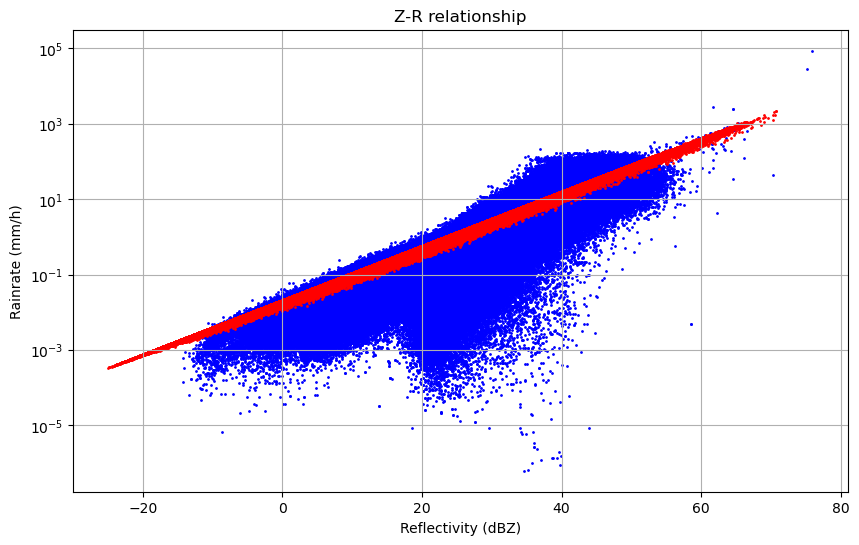

In [19]:
#scatter plot of dbz vs rainrate
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values.flatten(),rainrate2[indexAP:-1,:,:].values.flatten(),s=1,color='blue',label='AP')
plt.scatter(dbz2[0:indexBP,:,:].values.flatten(),rainrate2[0:indexBP,:,:].values.flatten(),s=1,color='red',label='BP')
#plt.legend()
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
#plt.ylim(100,3000)
plt.grid()
plt.title('Z-R relationship')
plt.show()

#plt.savefig('../../figures/Fig_seapol_ZR_scatter.png')

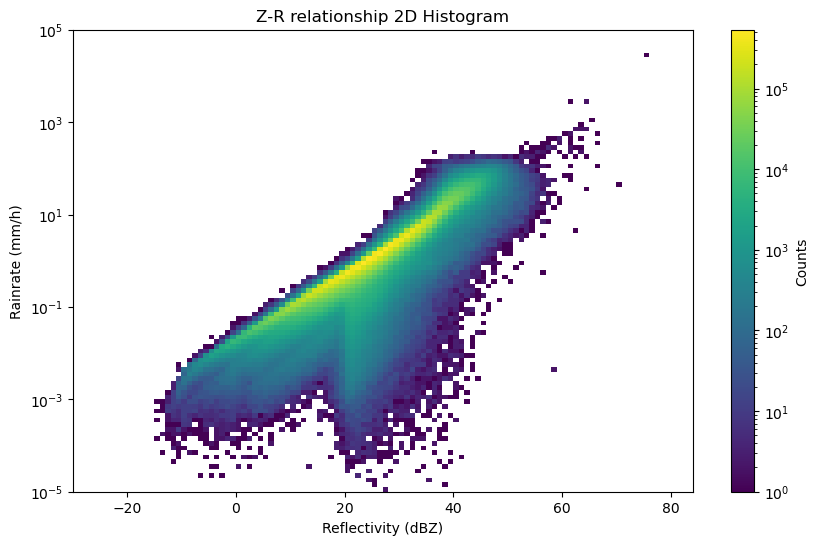

In [16]:
# Prepare data for 2D histogram
#dbz_flat = dbz2.values.flatten()
#rainrate_flat = rainrate2.values.flatten()
dbz_flat = dbz2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time
rainrate_flat = rainrate2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time

# Filter out NaN values
mask = ~np.isnan(dbz_flat)
dbz_flat_filtered = dbz_flat[mask]
rainrate_flat_filtered = rainrate_flat[mask]

# Calculate 2D histogram
pbins = np.concatenate((np.arange(0,1e-4,1e-5),np.arange(1e-4,1e-3,1e-4),np.arange(1e-3,0.01,1e-3),np.arange(0.01,0.1,0.01),np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100),np.arange(1000,10000,1000),np.arange(10000,100000,10000)))
pbins = np.concatenate(([0],np.power(10,np.arange(-5,5,0.1))))
dbzbins = np.arange(-30,85,1)
hist, xedges, yedges = np.histogram2d(dbz_flat_filtered, np.transpose(rainrate_flat_filtered), bins=[dbzbins, pbins],range=[[-30, 80], [0, 100000]])

# Plot 2D histogram
plt.figure(figsize=(10,6))
dbzmesh,pmesh = np.meshgrid(xedges, yedges)
plt.pcolormesh(dbzmesh, pmesh, hist.T, norm=LogNorm(), cmap='viridis', shading='auto')
#plt.imshow(hist.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Counts')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(1e-5,1e5)
plt.title('Z-R relationship 2D Histogram')
plt.show()

In [78]:
pmesh

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [1.e-01, 1.e-01, 1.e-01, ..., 1.e-01, 1.e-01, 1.e-01],
       [2.e-01, 2.e-01, 2.e-01, ..., 2.e-01, 2.e-01, 2.e-01],
       ...,
       [7.e+04, 7.e+04, 7.e+04, ..., 7.e+04, 7.e+04, 7.e+04],
       [8.e+04, 8.e+04, 8.e+04, ..., 8.e+04, 8.e+04, 8.e+04],
       [9.e+04, 9.e+04, 9.e+04, ..., 9.e+04, 9.e+04, 9.e+04]],
      shape=(60, 115))

In [46]:
seapol.time[np.where(rain245 == np.nanmax(rain245))]


<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2024-09-07T14:40:45.632000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-07T14:40:45.632000
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

In [63]:
np.where(seapol.RAINRATE[4319,:,:] == np.nanmax(seapol.RAINRATE[4319,:,:].values))

(array([239]), array([211]))

In [76]:
seapol.DBZ[4319,239,211].values

array(75.95426, dtype=float32)

In [77]:
seapol.DBZ[4319,239,212].values

array(75.11272, dtype=float32)

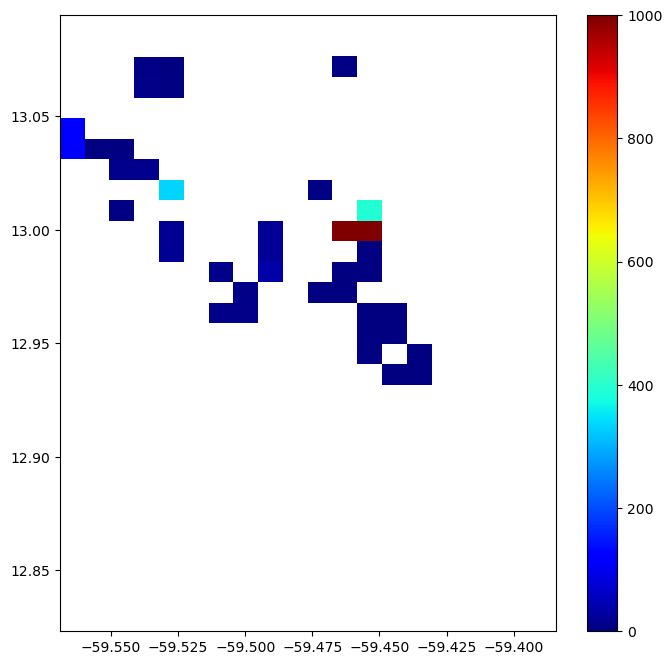

In [65]:
fig.ax = plt.subplots(figsize=(8,8))
plt.pcolormesh(seapol.longitude[4319,220:250,200:220], seapol.latitude[4319,220:250,200:220], seapol.RAINRATE[4319,220:250,200:220], cmap='jet',vmin=0,vmax=1000)
plt.colorbar()

/tmp/ipykernel_2731717/3769374052.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/3769374052.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0')]

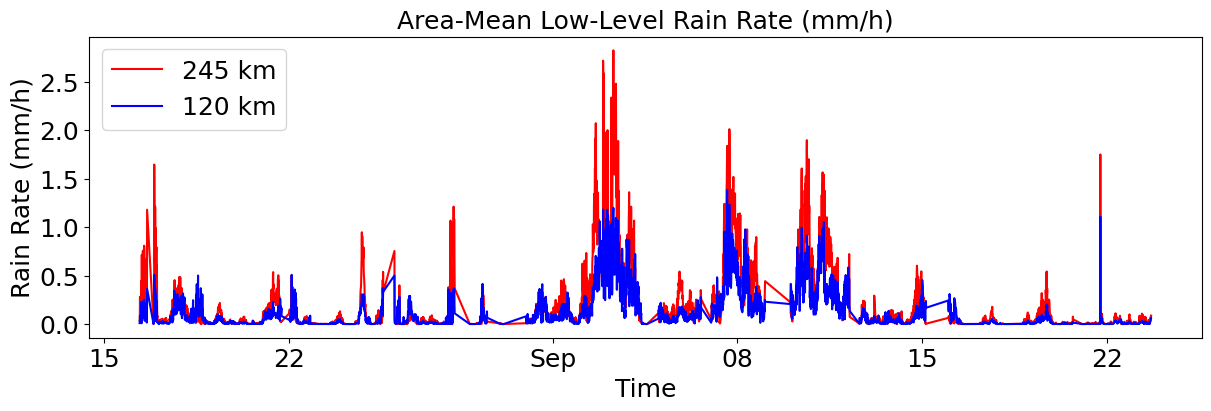

In [49]:
#Plot for whole campaign (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time, rain120, color='red', label='245 km')
ax.plot(seapol.time, rain245, color='blue', label='120 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

#ax.set_ylim(0, 4)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_2731717/3883083542.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/3883083542.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -20.0, '−20'),
 Text(0, 0.0, '0'),
 Text(0, 20.0, '20'),
 Text(0, 40.0, '40'),
 Text(0, 60.0, '60'),
 Text(0, 80.0, '80'),
 Text(0, 100.0, '100')]

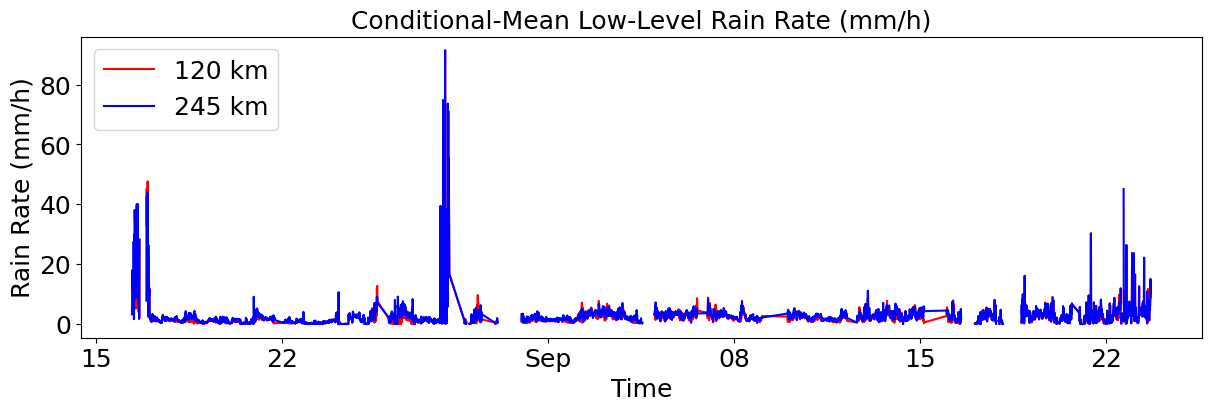

In [52]:
#Plot rain intensity (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time, rain120cond, color='red', label='120 km')
ax.plot(seapol.time, rain245cond, color='blue', label='245 km')
ax.set_title('Conditional-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_2731717/3443877530.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/3443877530.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0')]

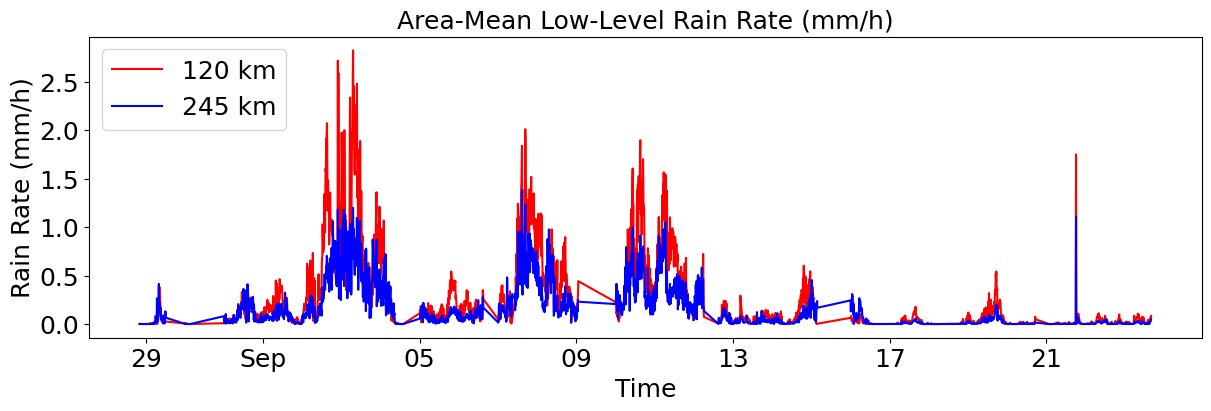

In [53]:
#Plot for AP period (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time[indexAP:-1], rain120[indexAP:-1], color='red', label='120 km')
ax.plot(seapol.time[indexAP:-1], rain245[indexAP:-1], color='blue', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_2731717/1035932196.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/1035932196.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -10.0, '−10'),
 Text(0, 0.0, '0'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 30.0, '30'),
 Text(0, 40.0, '40'),
 Text(0, 50.0, '50')]

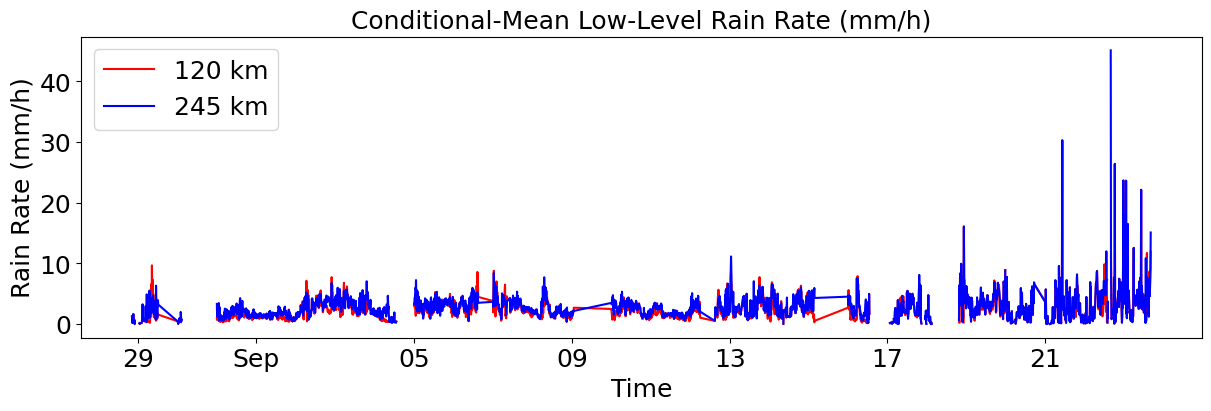

In [54]:
#Plot rain intensity for AP period (10 minute data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(seapol.time[indexAP:-1], rain120cond[indexAP:-1], color='red', label='120 km')
ax.plot(seapol.time[indexAP:-1], rain245cond[indexAP:-1], color='blue', label='245 km')
ax.set_title('Conditional-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

/tmp/ipykernel_2731717/966359471.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/966359471.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0')]

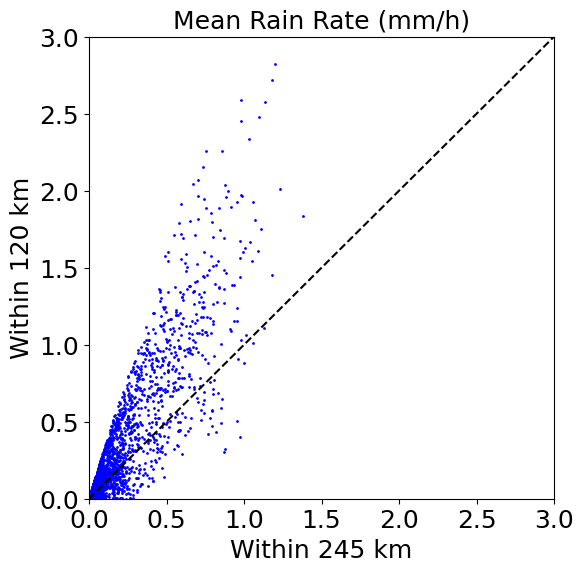

In [67]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245[indexAP:-1], rain120[indexAP:-1],s=1,color='blue',label='Mean Rain Rate')

#Plot 1:1 line
x = np.linspace(0, 3, 100)
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 120 km', fontsize=18)
ax.set_title('Mean Rain Rate (mm/h)', fontsize=18)

ax.set_xlim(0,3)
ax.set_ylim(0,3)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


/tmp/ipykernel_2731717/374381236.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/374381236.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, 0.0, '0'),
 Text(0, 5.0, '5'),
 Text(0, 10.0, '10'),
 Text(0, 15.0, '15'),
 Text(0, 20.0, '20'),
 Text(0, 25.0, '25'),
 Text(0, 30.0, '30')]

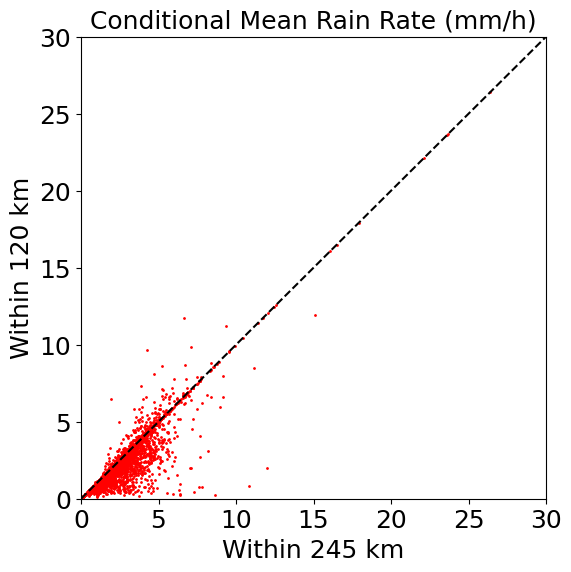

In [72]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain245cond[indexAP:-1], rain120cond[indexAP:-1],s=1,color='red',label='Rain Intensity')

#Plot 1:1 line
x = np.linspace(0, 30, 100)
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 120 km', fontsize=18)

ax.set_title('Conditional Mean Rain Rate (mm/h)', fontsize=18)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

In [81]:
# Search times
time1 = np.datetime64('2024-09-21T18:00:00')
time2 = np.datetime64('2024-09-21T18:30:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(seapol.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(seapol.time) - time2).argmin()

/tmp/ipykernel_2731717/618504414.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2731717/618504414.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.2, '−0.2'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4000000000000001, '0.4'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0000000000000002, '1.0'),
 Text(0, 1.2000000000000002, '1.2')]

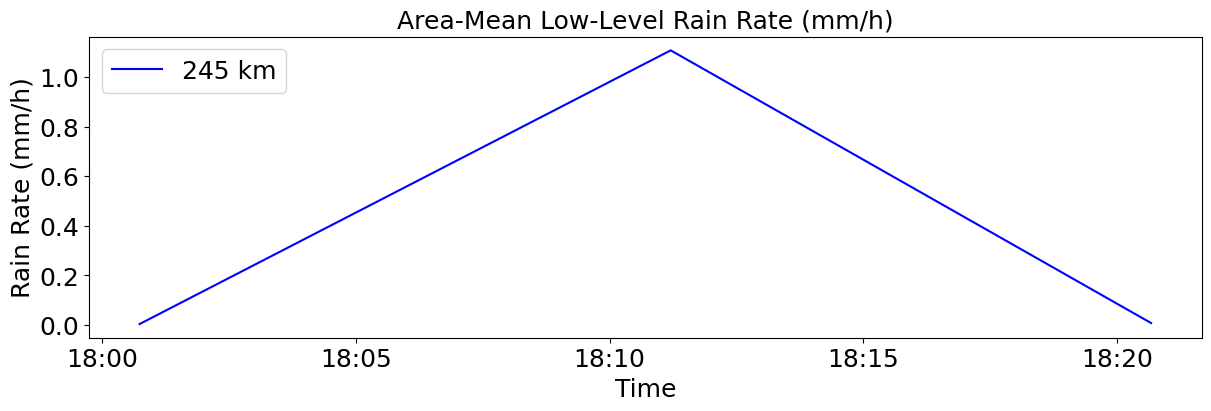

In [82]:
#Plot time series

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(seapol.time[index1:index2], rain245[index1:index2], color='blue', label='245 km')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

In [86]:
seapol.time[index1:index2]

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2024-09-21T18:00:44.263000064', '2024-09-21T18:11:12.288000000',
       '2024-09-21T18:20:40.372000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2024-09-21T18:00:44.263000064 ... 2024...
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

In [91]:
index1

np.int64(4173)

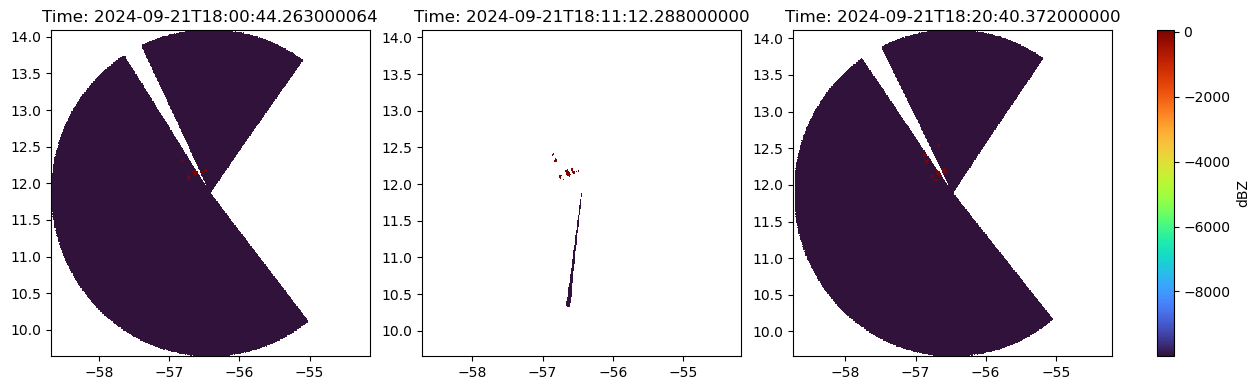

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

#axes[0,0].pcolormesh(seapol.longitude[4173,250:310,180:260], seapol.latitude[4173,250:310,180:260], rainrate4[4173,250:310,180:260], cmap='turbo')
#axes[0,1].pcolormesh(seapol.longitude[4174,250:310,180:260], seapol.latitude[4174,250:310,180:260], rainrate4[4174,250:310,180:260], cmap='turbo')
axes[0].pcolormesh(seapol.longitude[4173,:,:], seapol.latitude[4173,:,:], seapol.DBZ[4173,:,:], cmap='turbo')
axes[1].pcolormesh(seapol.longitude[4174,:,:], seapol.latitude[4174,:,:], seapol.DBZ[4174,:,:], cmap='turbo')
axes[2].pcolormesh(seapol.longitude[4175,:,:], seapol.latitude[4175,:,:], seapol.DBZ[4175,:,:], cmap='turbo')

axes[0].set_title(f'Time: {seapol.time[4173].values}', fontsize=12)
axes[1].set_title(f'Time: {seapol.time[4174].values}', fontsize=12) 
axes[2].set_title(f'Time: {seapol.time[4175].values}', fontsize=12)

fig.tight_layout()
cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('dBZ')

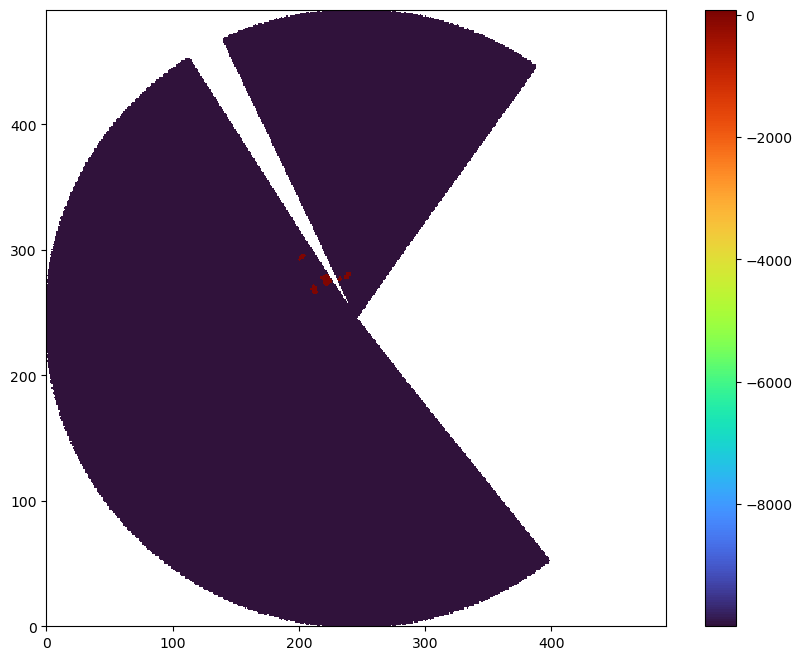

In [23]:
fig,axes = plt.subplots(figsize=(10,8))

#cmap_dbz = mcolors.ListedColormap(['white'] + list(plt.cm.get_cmap('radar.reflectivity')(np.linspace(0, 1, 256))))
#cmap_dbz.set_bad('silver')
#bounds = [-9999, -100, 60]

plt.pcolormesh(seapol.RAINRATE[4173,:,:], cmap='turbo')
plt.colorbar()

In [32]:
seapol.RAINRATE[4173,350,100].values 

array(-9999., dtype=float32)

In [31]:
seapol.RAINRATE[4174,350,100].values

array(nan, dtype=float32)